<a href="https://colab.research.google.com/github/envirodatascience/final-project-wildfire/blob/main/GroupData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfires in the United States

This project examines the landscape of wildfires in the US from 1984-2024. We aim to answer the following questions using data from the US Geological Service that monitors trends in burn severity over this time period:

1) How has wildfire frequency changed over time in the US?

2) How has wildfire severity changed over time in the US?

3) Is prescribed burning an effective policy for mitigating fires?

In [ ]:
# import packages
import pandas as pd
import numpy as np

import geopandas as gpd
from plotnine import *
import plotnine

import scipy.stats as stats
import statsmodels.api as sm

# Upload Data
We are pulling data from The Monitoring Trends in Burn Severity (MTBS) Program provided by the USGS and USDA Forest Service

The data provides info regarding all currently inventoried fires occurring between calendar year 1984 and 2024 for CONUS, Alaska, Hawaii, and Puerto Rico.

In [ ]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#upload fire severity data
! unzip /content/drive/MyDrive/mtbs_perims_DD.zip #unpacks zipped folder


Archive:  /content/drive/MyDrive/mtbs_perims_DD.zip
  inflating: mtbs_perims_DD.cpg      
  inflating: mtbs_perims_DD.dbf      
  inflating: mtbs_perims_DD.prj      
  inflating: mtbs_perims_DD.sbn      
  inflating: mtbs_perims_DD.sbx      
  inflating: mtbs_perims_DD.shp      
  inflating: mtbs_perims_DD.shp.xml  
  inflating: mtbs_perims_DD.shx      
  inflating: mtbs_perims_DD_ISO_metadata.xml  
  inflating: mtbs_perims_DD_metadata.xml  


In [ ]:
shape = "mtbs_perims_DD.shp"
df = gpd.read_file(shape) #reads in shape file

#Orienting and Data Cleaning

In [ ]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30331 entries, 0 to 30330
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Event_ID    30331 non-null  object        
 1   irwinID     6264 non-null   object        
 2   Incid_Name  30331 non-null  object        
 3   Incid_Type  30331 non-null  object        
 4   Map_ID      30331 non-null  int64         
 5   Map_Prog    30331 non-null  object        
 6   Asmnt_Type  30331 non-null  object        
 7   BurnBndAc   30331 non-null  int64         
 8   BurnBndLat  30331 non-null  object        
 9   BurnBndLon  30331 non-null  object        
 10  Ig_Date     30331 non-null  datetime64[ms]
 11  Pre_ID      22056 non-null  object        
 12  Post_ID     30331 non-null  object        
 13  Perim_ID    2878 non-null   object        
 14  dNBR_offst  30331 non-null  int64         
 15  dNBR_stdDv  30331 non-null  int64         
 16  NoData_T    30

In [ ]:
df.head()

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,AK6260315742119850801,None,CAMELBACK,Wildfire,4737,MTBS,Extended,4780,62.603,-157.421,...,None,27,-9999,-970,-150,130,334,585,None,"POLYGON ((-157.44988 62.62182, -157.44895 62.6..."
1,AK6256215664519850720,None,SUGARLOAF,Wildfire,4738,MTBS,Extended,5489,62.562,-156.645,...,None,3,-9999,-970,-150,70,320,600,None,"POLYGON ((-156.69736 62.57441, -156.70027 62.5..."
2,AK6547615382919850801,None,TAL NW 44,Wildfire,4739,MTBS,Extended,1491,65.476,-153.829,...,None,14,-9999,-970,-150,50,275,530,None,"POLYGON ((-153.84454 65.46265, -153.84574 65.4..."
3,AK6521015526519850803,None,GAL NE 48,Wildfire,4740,MTBS,Extended,1298,65.210,-155.265,...,None,14,-9999,-970,-150,100,321,580,None,"POLYGON ((-155.27031 65.22507, -155.26915 65.2..."
4,AZ3178311066219850302,None,UNNAMED,Wildfire,4741,MTBS,Initial,1326,31.783,-110.662,...,None,-10,-9999,-970,-150,25,152,320,Hard to delineate fire perimeter,"POLYGON ((-110.6733 31.75345, -110.67378 31.75..."


In [ ]:
df['State'] = df['Event_ID'].str[:2] #create state column from event ID
df['State'].unique()

array(['AK', 'AZ', 'SD', 'CA', 'WA', 'OR', 'FL', 'NV', 'CO', 'ID', 'NM',
       'UT', 'WY', 'MT', 'NE', 'AL', 'GA', 'NC', 'SC', 'LA', 'ME', 'MI',
       'MN', 'NJ', 'VA', 'NY', 'AR', 'DE', 'MS', 'ND', 'TX', 'KY', 'TN',
       'WI', 'MO', 'WV', 'MD', 'KS', 'OK', 'IN', 'IA', 'HI', 'OH', 'MA',
       'PA', 'PR', 'IL'], dtype=object)

In [ ]:
df_state = df.pop('State')
df.insert(0,'State',df_state)
df.head()

,State,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,AK,AK6260315742119850801,None,CAMELBACK,Wildfire,4737,MTBS,Extended,4780,62.603,...,None,27,-9999,-970,-150,130,334,585,None,"POLYGON ((-157.44988 62.62182, -157.44895 62.6..."
1,AK,AK6256215664519850720,None,SUGARLOAF,Wildfire,4738,MTBS,Extended,5489,62.562,...,None,3,-9999,-970,-150,70,320,600,None,"POLYGON ((-156.69736 62.57441, -156.70027 62.5..."
2,AK,AK6547615382919850801,None,TAL NW 44,Wildfire,4739,MTBS,Extended,1491,65.476,...,None,14,-9999,-970,-150,50,275,530,None,"POLYGON ((-153.84454 65.46265, -153.84574 65.4..."
3,AK,AK6521015526519850803,None,GAL NE 48,Wildfire,4740,MTBS,Extended,1298,65.210,...,None,14,-9999,-970,-150,100,321,580,None,"POLYGON ((-155.27031 65.22507, -155.26915 65.2..."
4,AZ,AZ3178311066219850302,None,UNNAMED,Wildfire,4741,MTBS,Initial,1326,31.783,...,None,-10,-9999,-970,-150,25,152,320,Hard to delineate fire perimeter,"POLYGON ((-110.6733 31.75345, -110.67378 31.75..."


In [ ]:
df['Incid_Type'].unique()

array(['Wildfire', 'Prescribed Fire', 'Unknown', 'Wildland Fire Use'],
      dtype=object)

In [16]:
# clean columns
df_columns = df.drop(columns=['Event_ID', 'irwinID', 'Map_ID', 'Map_Prog', 'Asmnt_Type', 'Pre_ID', 'Post_ID', 'Perim_ID', 'Comment'])
df_columns.head()

,State,Incid_Name,Incid_Type,BurnBndAc,BurnBndLat,BurnBndLon,Ig_Date,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,geometry
0,AK,CAMELBACK,Wildfire,4780,62.603,-157.421,1985-08-01,27,-9999,-970,-150,130,334,585,"POLYGON ((-157.44988 62.62182, -157.44895 62.6..."
1,AK,SUGARLOAF,Wildfire,5489,62.562,-156.645,1985-07-20,3,-9999,-970,-150,70,320,600,"POLYGON ((-156.69736 62.57441, -156.70027 62.5..."
2,AK,TAL NW 44,Wildfire,1491,65.476,-153.829,1985-08-01,14,-9999,-970,-150,50,275,530,"POLYGON ((-153.84454 65.46265, -153.84574 65.4..."
3,AK,GAL NE 48,Wildfire,1298,65.210,-155.265,1985-08-03,14,-9999,-970,-150,100,321,580,"POLYGON ((-155.27031 65.22507, -155.26915 65.2..."
4,AZ,UNNAMED,Wildfire,1326,31.783,-110.662,1985-03-02,-10,-9999,-970,-150,25,152,320,"POLYGON ((-110.6733 31.75345, -110.67378 31.75..."


In [25]:
#check for missing/null values
df_columns['dNBR_stdDv'].unique()
df_columns['dNBR_stdDv'] = df_columns['dNBR_stdDv'].replace('-9999', np.nan)
df_columns['dNBR_stdDv'].unique()

array([None], dtype=object)

#Upload State County Polygons

In [ ]:
! unzip /content/drive/MyDrive/cb_2018_us_county_500k.zip #unpacks zipped folder

Archive:  /content/drive/MyDrive/cb_2018_us_county_500k.zip
  inflating: cb_2018_us_county_500k.shp.ea.iso.xml  
  inflating: cb_2018_us_county_500k.shp.iso.xml  
  inflating: cb_2018_us_county_500k.shp  
  inflating: cb_2018_us_county_500k.shx  
  inflating: cb_2018_us_county_500k.dbf  
  inflating: cb_2018_us_county_500k.prj  
 extracting: cb_2018_us_county_500k.cpg  


In [ ]:
shp = "cb_2018_us_county_500k.shp"
df_counties = gpd.read_file(shp) #reads in shape file
df_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


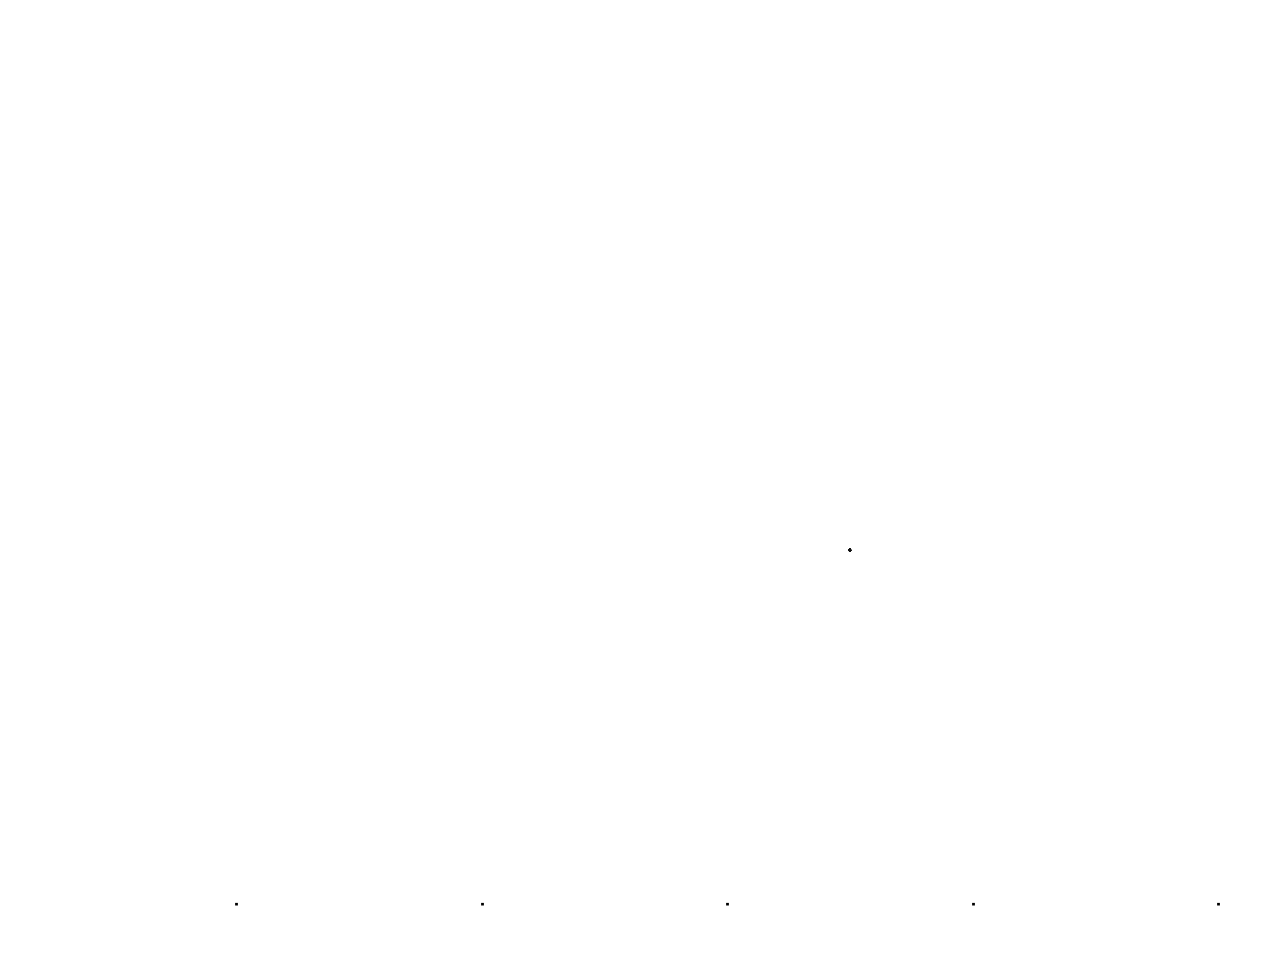

In [ ]:
#plot spatial data

(ggplot()
  + geom_map(df_counties, aes(geometry = 'geometry', fill='STATEFP'), show_legend = False)
  + labs(fill='STATEFP')
  + xlim(-5e6,3e6)
  + ylim(-2.5e6, 4e6)
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
  # + xlab("")
  # + ylab("")
 )

#Initial Zoom in on State Data

In [ ]:
CA_df = df[df['State'] == 'CA']

CA_df.head()

,State,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
13,CA,CA3601111879719850712,None,TULARE 4,Wildfire,4752,MTBS,Initial,1290,36.011,...,None,62,-9999,-970,-150,90,233,425,None,"POLYGON ((-118.78172 35.99641, -118.78252 35.9..."
36,CA,CA3544311877719850503,None,ADELAIDE,Wildfire,4776,MTBS,Initial,1054,35.443,...,None,2,-9999,-970,-150,50,300,9999,None,"POLYGON ((-118.7822 35.45334, -118.78119 35.45..."
37,CA,CA3672712076819850609,None,PONOCHE 2,Wildfire,4777,MTBS,Initial (SS),7508,36.727,...,None,-9999,-9999,9999,9999,-30,-9999,-9999,None,"POLYGON ((-120.79613 36.74672, -120.79633 36.7..."
38,CA,CA3590312056319850702,None,LOWES,Wildfire,4778,MTBS,Extended,2708,35.903,...,504303519850802,33,-9999,-970,-150,140,265,450,None,"POLYGON ((-120.571 35.89591, -120.57104 35.895..."
39,CA,CA3673911825219850706,None,ONION,Wildfire,4779,MTBS,Extended,8583,36.739,...,None,-34,-9999,-970,-150,-50,300,9999,grass fire hard to tell the perimeter,"POLYGON ((-118.22475 36.77746, -118.22551 36.7..."


In [ ]:
CA_df["dNBR_offst"].max()

200

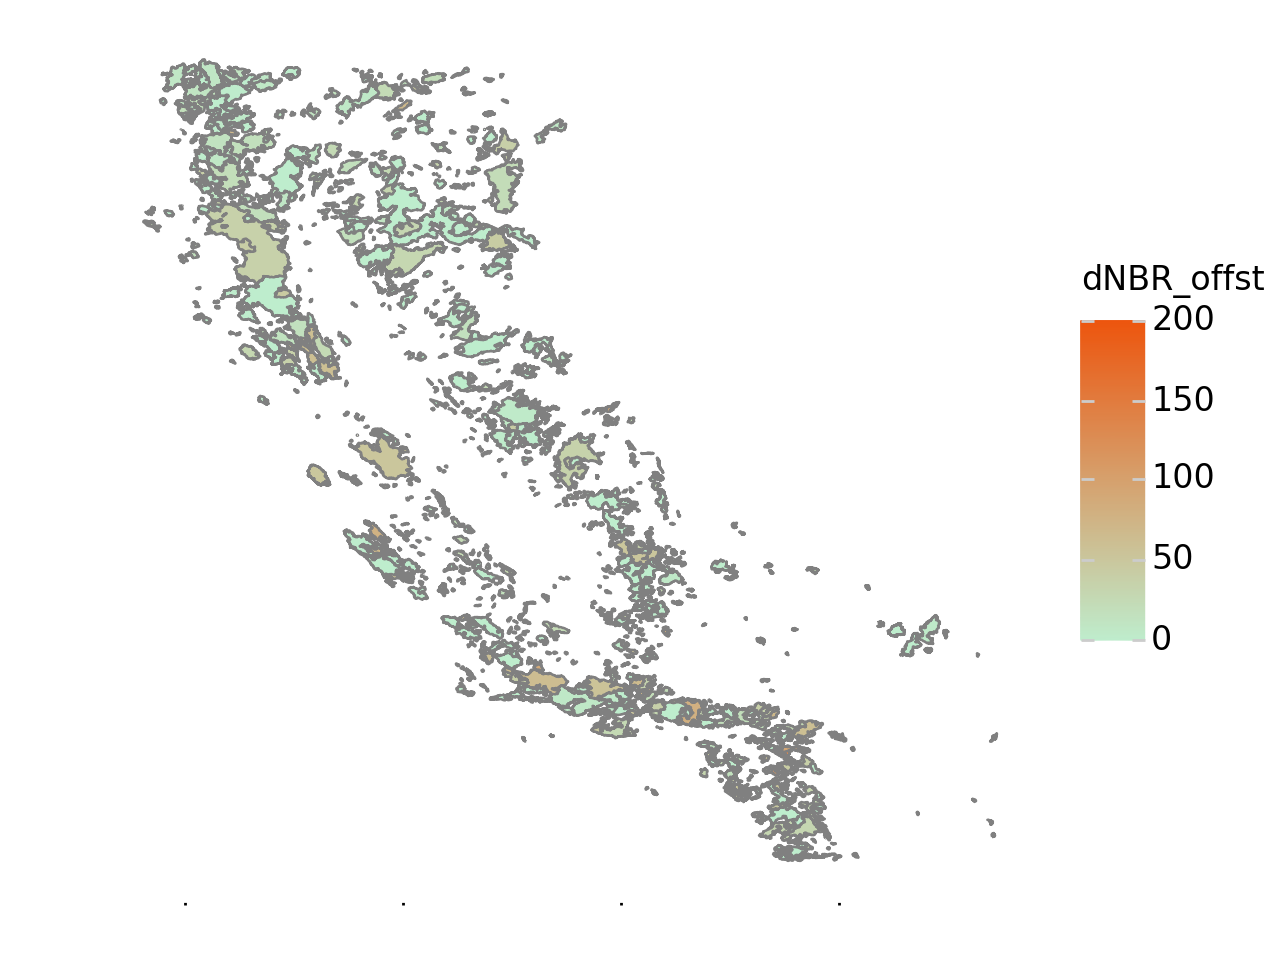

In [ ]:
#plot spatial data

(ggplot()
  + geom_map(CA_df, aes(geometry = 'geometry', fill = 'dNBR_offst'), color = 'grey')
  + scale_fill_gradientn(colors = ["#beedcd", "#ed550e"],limits = [0, 200])
  + labs(fill='dNBR_offst')
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
  # + xlab("")
  # + ylab("")
 )

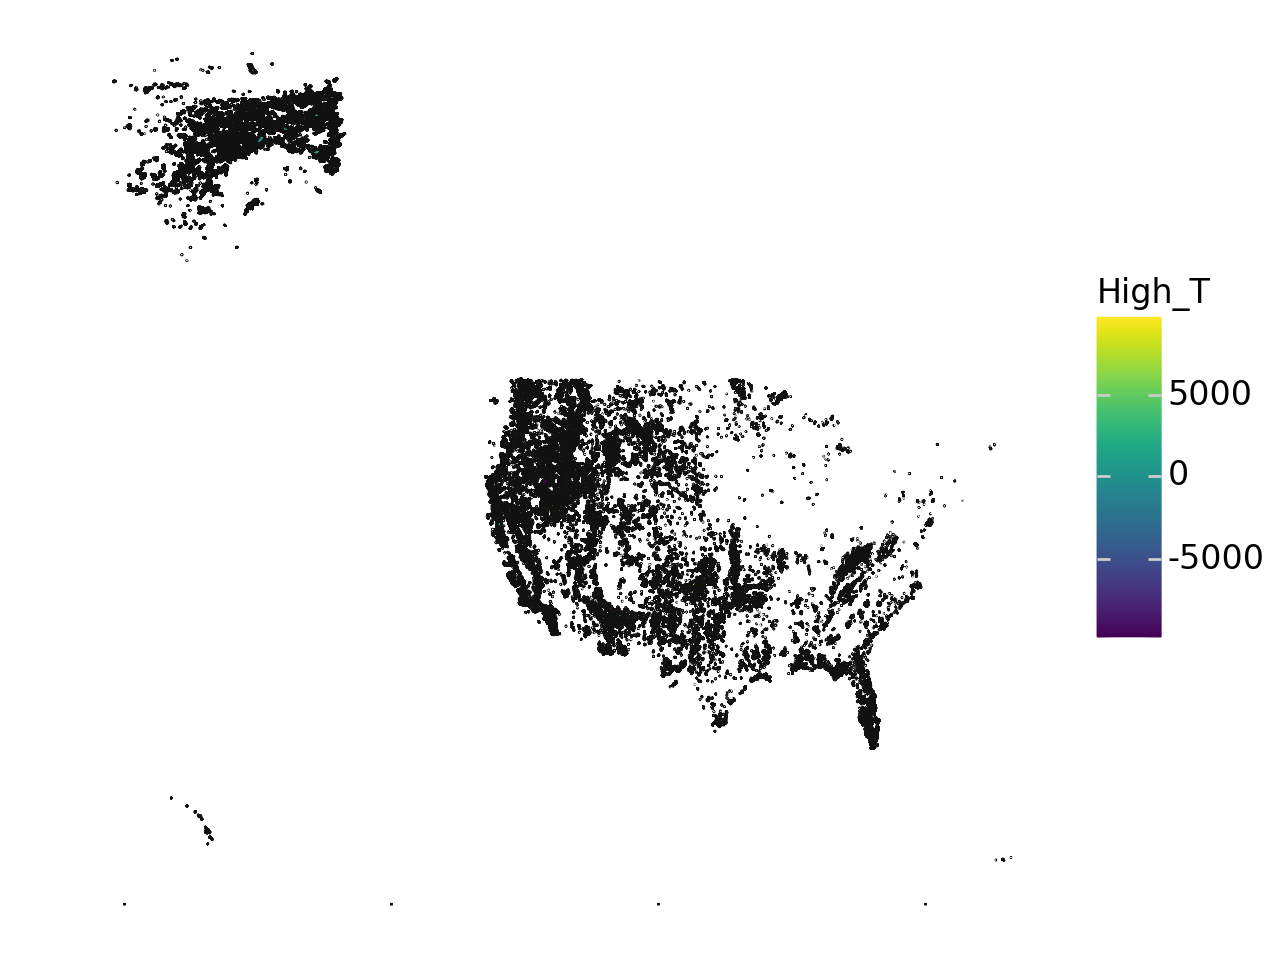

In [ ]:
#plot spatial data

(ggplot()
  + geom_map(df, aes(geometry = 'geometry', fill='High_T'))
  + labs(fill='High_T')
  + theme_classic()
  + theme(axis_line=element_line(color="white"),
          axis_ticks=element_line(color = "white"),
          axis_text=element_line(color='white'),
          text=element_text(size = 12))
  # + xlab("")
  # + ylab("")
 )